In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

def check_color_rgb(img):
    return img.ndim == 3 and img.shape[2] == 3

def show_compare_images(left_img, left_title, right_img, right_title):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        if check_color_rgb(left_img):
            ax1.imshow(left_img)
        else:
            ax1.imshow(left_img, cmap='gray')
        ax1.set_title(left_title, fontsize=50)
        if check_color_rgb(right_img):
            ax2.imshow(right_img)
        else:
            ax2.imshow(right_img, cmap='gray')
        ax2.set_title(right_title, fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### camera calibration

In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline

nx = 9
ny = 6

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

def load_camera_cal_images():
    images = []
    for name in glob.glob('camera_cal/*.jpg'):
        img = cv2.imread(name)
        images.append(img)
    return images

def get_points(images, objpoints, imgpoints):
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

def save_calibration_info(mtx, dist):
    with open('mtx.pkl', 'wb') as f:
        pickle.dump(mtx, f)
    with open('dist.pkl', 'wb') as f:
        pickle.dump(dist, f)
        
def check_mean_error(objpoints, imgpoints, rvecs, tvecs, mtx, dist):
    mean_error = 0
    for i in range(0, len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    print("mean_error: ", mean_error/len(objpoints)) 

def save_undistored_images(images, mtx, dist):
    for i, img in enumerate(images):
        undistorted = cv2.undistort(img, mtx, dist, None, mtx)
        show_compare_images(img, 'Original Image', undistorted, 'Undistorted Image')
        plt.savefig("output_images/undistort_output_" + str(i) + ".png")
        
def camera_calibrate():
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    images = load_camera_cal_images()

    get_points(images, objpoints, imgpoints)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, images[0].shape[1::-1], None, None)
    save_calibration_info(mtx, dist)

    check_mean_error(objpoints, imgpoints, rvecs, tvecs, mtx, dist)
    save_undistored_images(images, mtx, dist)
    
camera_calibrate()

### distortion-corrected image

In [2]:
import pickle  
import cv2
import matplotlib.image as mpimg

img_test5 = mpimg.imread("./test_images/test5.jpg")

with open('mtx.pkl', 'rb') as f:
    mtx = pickle.load(f)
with open('dist.pkl', 'rb') as f:
    dist = pickle.load(f)
        
img_test5_undistorted = cv2.undistort(img_test5, mtx, dist, None, mtx)
show_compare_images(img_test5, 'Original Image', img_test5_undistorted, 'Undistorted Image')
plt.savefig("output_images/undistort_output_test5.png")

/Users/takashi/Documents/SelfDrivingCar/CarND-Advanced-Lane-Lines


NameError: name 'show_compare_images' is not defined

### sobel operator

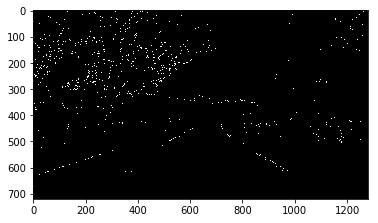

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_test5 = mpimg.imread("./test_images/test5.jpg")

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    s_binary = np.zeros_like(gray)
    s_binary[(gradmag > thresh[0]) & (gradmag <= thresh[1])] = 1
    return s_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def combine_threshold(image, 
                      gx_th_min=31, gx_th_max=80,
                      gy_th_min=41, gy_th_max=112, 
                      mg_th_min=37, mg_th_max=119,
                      dir_kernel_size=15, dir_th_min=0.7, dir_th_max=1.3):
    ksize = 3
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(gx_th_min, gx_th_max))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(gy_th_min, gy_th_max))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(mg_th_min, mg_th_max))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(dir_th_min, dir_th_max))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

from ipywidgets import interact
@interact(gx_th_min=(0,255,1), gx_th_max=(0,255,1), 
          gy_th_min= (0,255,1),gy_th_max= (0,255,1), 
          mg_th_min=(0,255,1), mg_th_max=(0,255,1), 
          dir_kernel_size=(0,30,1), dir_th_min=(0,np.pi/2),dir_th_max=(0,np.pi/2))
def combine_threshold_interact(gx_th_min=31,gx_th_max=80,
                               gy_th_min=41, gy_th_max=112, 
                               mg_th_min=37,mg_th_max=119,
                               dir_kernel_size=15, dir_th_min=0.7,dir_th_max=1.3):
    ksize = 3
    combined = combine_threshold(img_test5, gx_th_min, gx_th_max, gy_th_min, 
                                 gy_th_max, mg_th_min, mg_th_max, dir_th_min, dir_th_max)
    plt.imshow(combined, cmap='gray')
    plt.show()

    




### color space

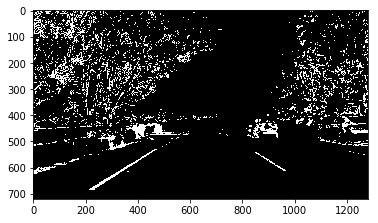

In [56]:
import cv2
import matplotlib.pyplot as plt

def color_space(img, s_th_min=167, s_th_max=255):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]    
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_th_min <= s_channel) & (s_th_max >= s_channel)] = 1    
    return color_binary
    
from ipywidgets import interact
@interact(s_th_min=(0,255,1), s_th_max=(0,255,1))
def color_space_interact(s_th_min=167, s_th_max=255):
    color_binary = color_space(img_test5, s_th_min, s_th_max)
    plt.imshow(color_binary, cmap='gray')
    plt.show()
                               

### color and gradient stack

(720, 1280)


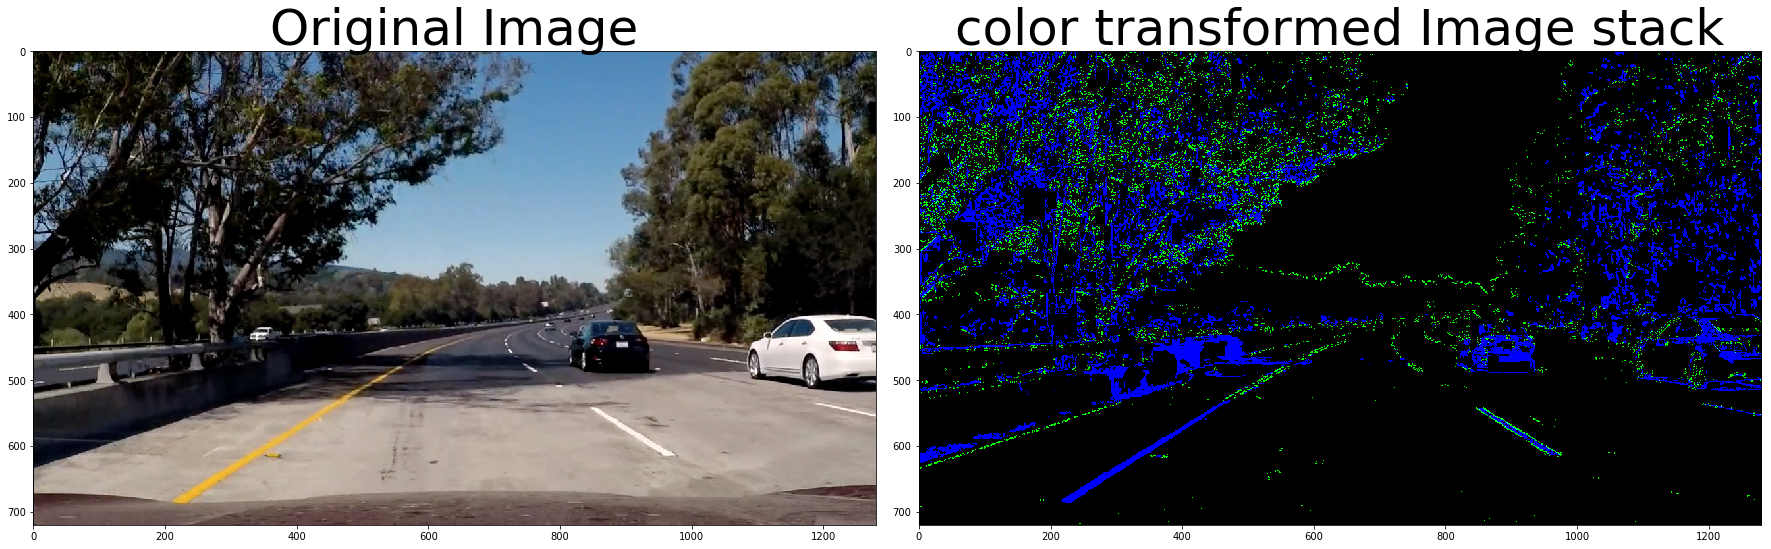

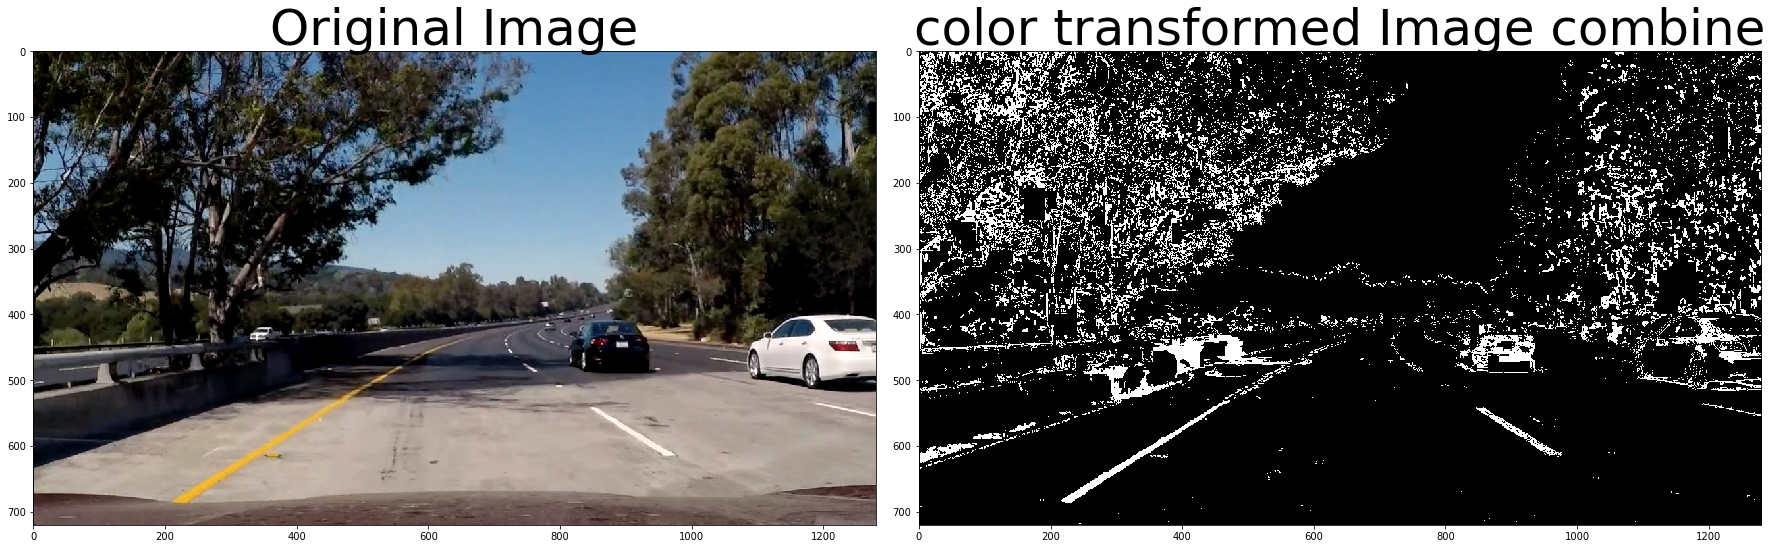

In [55]:
import cv2
import matplotlib.pyplot as plt


# Edit this function to create your own pipeline.
def pipeline_stack(img, s_thresh=(167, 255)):
    img = np.copy(img)
    sobel_binary = combine_threshold(img)
    s_channel = color_space(img)    
    color_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, s_channel))    
    return color_binary

def pipeline_combine(img, s_thresh=(167, 255)):
    img = np.copy(img)
    sobel_binary = combine_threshold(img)
    s_channel = color_space(img)    
    combine = np.zeros_like(s_channel)
    combine[(sobel_binary == 1) | (s_channel == 1)] = 1
    return combine
    
show_compare_images(img_test5, 'Original Image', pipeline_stack(img_test5), 'color transformed Image stack')
show_compare_images(img_test5, 'Original Image', pipeline_combine(img_test5), 'color transformed Image combine')

### perspective transform and provide an example of a transformed image

(720, 1280)


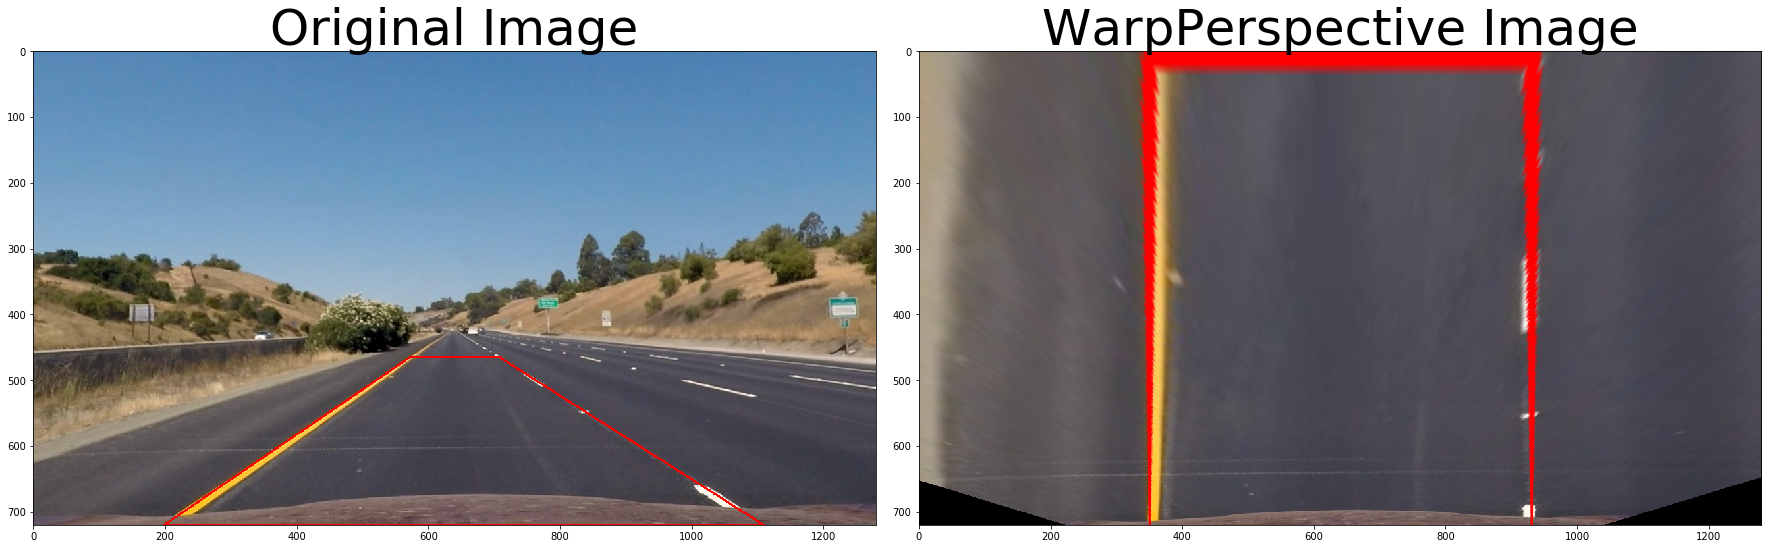

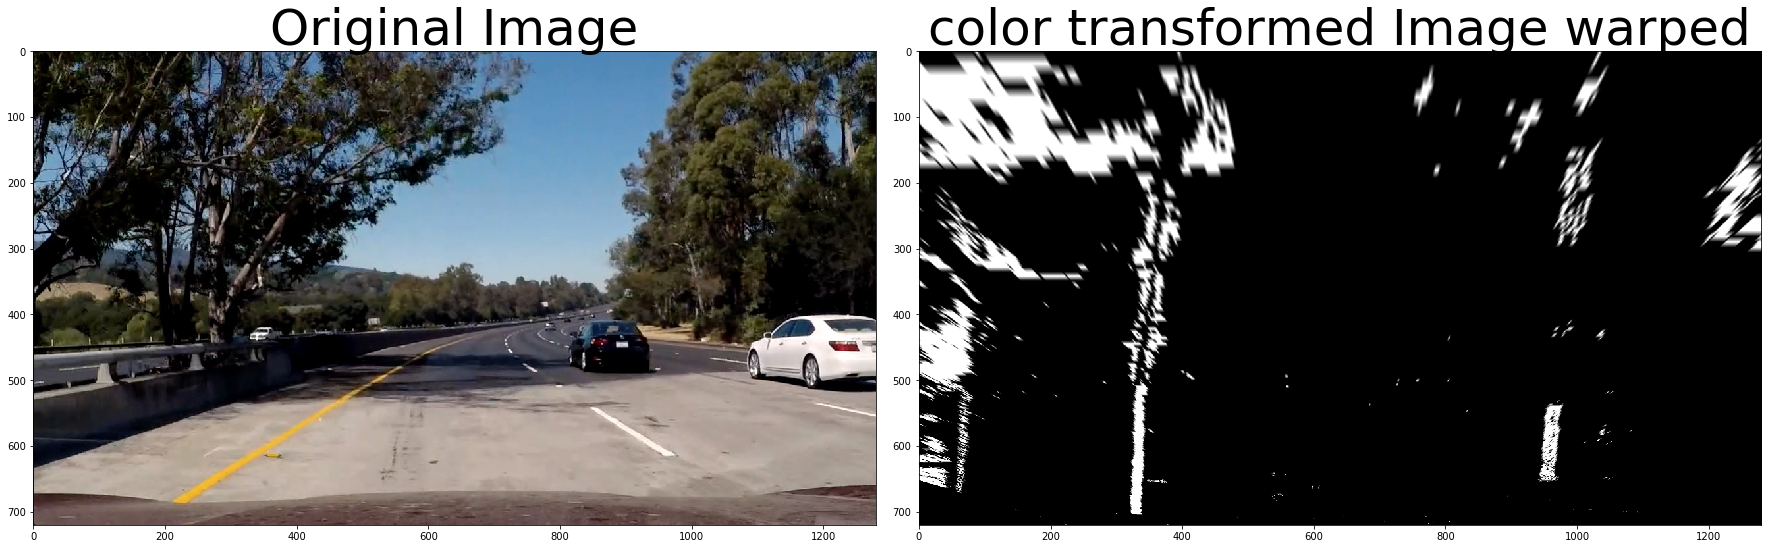

In [118]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import numpy as np

with open('mtx.pkl', 'rb') as f:
    mtx = pickle.load(f)
with open('dist.pkl', 'rb') as f:
    dist = pickle.load(f)

def PerspectiveTransformMatrix():
    src = np.float32([[198,720], [1110,720],[707,464],[573,464]])
    dst =np.float32([[350, 720], [930,720],[930,0],[350,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    
    def save_sample_image():
        straight_image = mpimg.imread("test_images/straight_lines1.jpg")
        straight_image = cv2.undistort(straight_image, mtx, dist, None, mtx)
        for i, p in enumerate(src):
            cv2.line(straight_image, tuple(p), tuple(src[(i+1) % 4]), (255,0,0), 2)
        warped = cv2.warpPerspective(straight_image, M, straight_image.shape[1::-1])
        
        show_compare_images(straight_image, 'Original Image', warped, 'WarpPerspective Image')
        plt.savefig("output_images/WarpPerspective.png")
        
    save_sample_image()
    return M

M = PerspectiveTransformMatrix()
img_test5_color_transformed_warped = cv2.warpPerspective(pipeline_combine(img_test5), M, img_test5_color_transformed.shape[1::-1])
show_compare_images(img_test5, 'Original Image', img_test5_color_transformed_warped, 'color transformed Image warped')


### Locate the Lane Lines and Fit a Polynomial

(720, 1280)


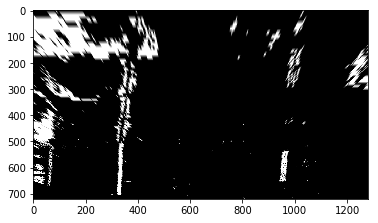

(720, 1280)


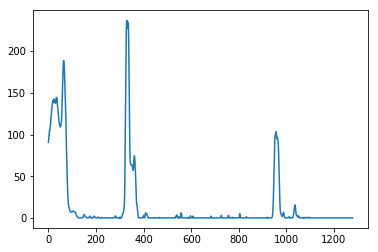

In [217]:
import numpy as np

img_test5_warped = cv2.warpPerspective(pipeline_combine(img_test5), M, img_test5_color_transformed.shape[1::-1])

binary_warped = img_test5_warped
plt.imshow(binary_warped, cmap='gray')
plt.show()

print(binary_warped.shape)

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()


In [229]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.ubyte)*255

print(out_img.dtype)
print(out_img.shape)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)


leftx_base = np.argmax(histogram[:midpoint]) #左側ピーク
rightx_base = np.argmax(histogram[midpoint:]) + midpoint #右側ピーク

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows) #高さ方向に9分割
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero() #np.transpose(nonzero)でインデックスの組み合わせを得る事が出来る
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
# margin = 100
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                      & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                       & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    if np.sum(good_left_inds) > 0:
        mean_left = np.mean(nonzerox[good_left_inds])
        if (len(good_left_inds) > minpix) and (np.fabs(mean_left - leftx_current) < 40):        
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            color_left = (0,255,0)
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        else:
            color_left = (255,0,0)       
        
    if np.sum(good_right_inds) > 0:
        mean_right = np.mean(nonzerox[good_right_inds])
        if (len(good_right_inds) > minpix) and (np.fabs(mean_right - rightx_current) < 40):        
            # Append these indices to the lists
            right_lane_inds.append(good_right_inds)
            color_right = (0,255,0)
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            color_right = (255,0,0)           
        
        
    # Draw the windows on the visualization image
    out_img = cv2.rectangle(out_img,(int(win_xleft_low),int(win_y_low)),(int(win_xleft_high),int(win_y_high)),color_left, 3) 
    out_img = cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),color_right, 3) 

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print(leftx.shape)
print(left_fit)


uint8
(720, 1280, 3)
(22548,)
[ -4.68797091e-05  -1.97597015e-02   3.63305589e+02]


(720, 0)

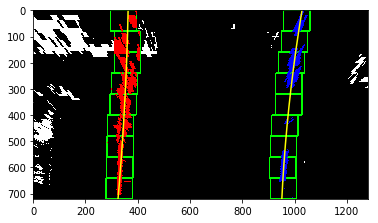

In [230]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [231]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                  & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
                   & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

50


(720, 0)

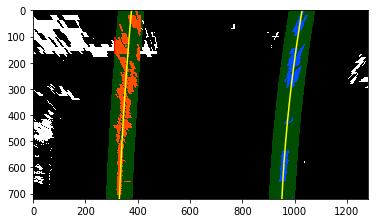

In [237]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.ubyte)*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

print(margin)

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

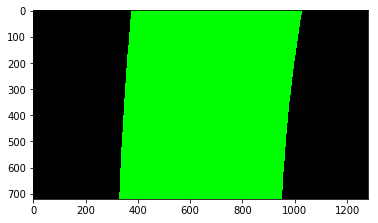

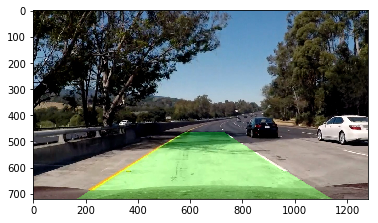

In [246]:
import numpy as np

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

plt.imshow(color_warp)
plt.show()

newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (warp_zero.shape[1], warp_zero.shape[0])) 
result = cv2.addWeighted(img_test5, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()

### Measuring Curvature

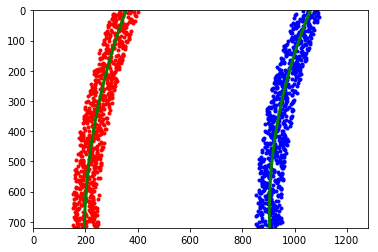

In [264]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

def fit_x(coef, y):
    return coef[0]*y**2 + coef[1]*y + coef[2]    

def fit(ploty, x, ym_per_pix=30/720, xm_per_pix=3.7/700):
    return np.polyfit(ploty*ym_per_pix, x*xm_per_pix, 2)
    
# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = fit(ploty, leftx, 1, 1)
left_fitx = fit_x(left_fit, ploty)
right_fit = fit(ploty, rightx, 1, 1)
right_fitx = fit_x(right_fit, ploty)

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images



In [269]:
y_eval = np.max(ploty)
print(y_eval)

def curvature(coef, ploty, ym_per_pix=30/720, xm_per_pix=3.7/700):
    y_eval = np.max(ploty)
    return ((1 + (2*coef[0]*y_eval*ym_per_pix + coef[1])**2)**1.5) / np.absolute(2*coef[0])

left_curverad = curvature(left_fit, ploty, 1, 1)
right_curverad = curvature(right_fit, ploty, 1, 1)
print(left_curverad, right_curverad)

719.0
1752.98716131 1436.52670814


In [272]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = fit(ploty, leftx) 
right_fit_cr = fit(ploty, rightx) 
# Calculate the new radii of curvature
left_curverad = curvature(left_fit_cr, ploty)
right_curverad = curvature(right_fit_cr, ploty)
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

575.559305697 m 471.009479146 m
